In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime, timedelta
import glob

/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/disk/sipn/mcmcgraw/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Load reforecasts 

In [66]:
model_name = 'ecmwf'
#model_name = 'ukmo'
model_type = 'reforecast'
no_day_change = 5

filepath_save = '/home/disk/sipn/mcmcgraw/data/VRILE/'
if model_name == 'ecmwf':
    filenames_full = glob.glob(filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time*.csv'.format(model_name=model_name,
                                                                                                                           model_type=model_type,
                                                                                                                           d_days=no_day_change))
    fname_test = pd.read_csv(filenames_full[0])
    d_SIE = pd.DataFrame(columns=fname_test.columns)
    for ifile in np.arange(0,len(filenames_full)):
        i_ds = pd.read_csv(filenames_full[ifile])
        if ifile == 0:
            d_SIE = i_ds
        else:
            d_SIE = d_SIE.append(i_ds)
#    
else:
    filename_full = filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
                       model_type=model_type,d_days=no_day_change)
    d_SIE = pd.read_csv(filename_full)
    #d_SIE_all = d_SIE.drop(columns='lead time (V - I)')
d_SIE_all=  d_SIE.dropna()
d_SIE_all.head()

,Unnamed: 0,I (init date),V (valid date),V_mon (valid date month),SIE,lead time (days),d_SIC (V - I),ensemble,region
0,0,1998-08-06,1998-08-08 00:00:00,8.0,6.914884,2.0,-0.206964,1.0,panArctic
1,0,1998-08-06,1998-08-09 00:00:00,8.0,6.914457,3.0,-0.182942,1.0,panArctic
2,0,1998-08-06,1998-08-10 00:00:00,8.0,6.815474,4.0,-0.166975,1.0,panArctic
3,0,1998-08-06,1998-08-11 00:00:00,8.0,6.767335,5.0,-0.197230,1.0,panArctic
4,0,1998-08-06,1998-08-12 00:00:00,8.0,6.747910,6.0,-0.151184,1.0,panArctic


Uncomment the next two cells if you want to add the forecasts to the analysis.   The first one reads in the forecast data

In [67]:
#model_type_2 = 'forecast'
#filename_full_2 = filepath_save+'{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=model_name,
#                       model_type=model_type_2,d_days=no_day_change)
#d_SIE_forecast = pd.read_csv(filename_full_2)
#d_SIE_forecast_trim = d_SIE_forecast.drop(columns=['V_mon (valid date month)','V_yr (valid date year)'])
#d_SIE_forecast_trim = d_SIE_forecast.dropna()
#d_SIE_forecast_trim.rename(columns={'d_SIC (V - I)':'d_SIE (V - I)'},inplace=True)
#d_SIE_forecast_trim.head()
#print(d_SIE_forecast['lead time (days)'].unique().tolist())
d_SIE_all['ensemble'].unique().tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Append forecast dataframe to reforecast

In [68]:
#d_SIE_all = d_SIE_all.append(d_SIE_forecast_trim)
#d_SIE_all = d_SIE_all[~d_SIE_all.index.duplicated()]
#d_SIE_all['lead time (days)'].iloc[-40:-1]
#d_SIE_all.loc[d_SIE_all['lead time (days)']==2].tail()
#d_SIE_all.iloc[-500::10]
#d_SIE_forecast.loc[d_SIE_forecast['lead time (days)']==2].dropna().tail()
#len(d_SIE_all.index.duplicated()==True)#.duplicated())

Now load observations from NSIDC bootstrap

In [69]:
obs_name = 'NSIDC_0079'
obs_type = 'sipn_nc_yearly_agg'
obs_filename = '/home/disk/sipn/mcmcgraw/data/VRILE/{model_name}_{model_type}_SIE_d_SIE_{d_days}day_change_lead_time_ALL_REGIONS_ALL_ENS.csv'.format(model_name=obs_name,
                       model_type=obs_type,d_days=no_day_change)
SIE_obs = pd.read_csv(obs_filename)
SIE_obs = SIE_obs.dropna()
#SIE_obs.tail()

Get lists of regions and lead days from model data. 

In [70]:
regions = d_SIE_all['region'].unique().tolist() #list unique regions
lead_days = d_SIE_all['lead time (days)'].unique().tolist() #list lead days

Group model data by lead day and choose a maximum lead.  Default is 2.  This code will include all days up to and included the maximum lead day.

In [71]:
#SIE_lead_groups = d_SIE_all.groupby(['lead time (days)'])
lead_day_choose = 2.0
lead_day_sel = np.arange(0,lead_day_choose+1)
lead_day_max = lead_day_sel[-1]
SIE_lead_sel = d_SIE_all.loc[d_SIE_all['lead time (days)']==lead_day_max]
SIE_model_dates = pd.to_datetime(SIE_lead_sel['V (valid date)'])
print('max lead day is ',lead_day_max)
#foo = d_SIE_forecast.loc[d_SIE_forecast['lead time (days)']==2]
#foo.tail()
#SIE_lead_sel.tail()

max lead day is  2.0


Keep only observations that match dates associated with model lead times.  

In [72]:
SIE_obs_dates = pd.to_datetime(SIE_obs['V (valid date)'])
f_dates = SIE_obs_dates.isin(SIE_model_dates)
SIE_obs_trim = SIE_obs.loc[f_dates]
SIE_obs_trim.tail()

,Unnamed: 0,V (valid date),V_mon (valid date month),SIE,d_SIC (V - I),ensemble,region
186102,10790,2018-07-20,7.0,2.656283,-0.091464,obs,East-Siberian-Beaufort-Chukchi
186106,10794,2018-07-24,7.0,2.487564,-0.096033,obs,East-Siberian-Beaufort-Chukchi
186109,10797,2018-07-27,7.0,2.460459,-0.103204,obs,East-Siberian-Beaufort-Chukchi
186113,10801,2018-07-31,7.0,2.183618,-0.238828,obs,East-Siberian-Beaufort-Chukchi
186116,10804,2018-08-03,8.0,2.205929,0.017254,obs,East-Siberian-Beaufort-Chukchi


Loop through regions and years to calculate model SIE bias vs. year. Bias is defined as <code>model - obs</code>.  That is, for a given region, we calculate the mean SIE across all ensemble members of the model at each date; and we subtract the average of the observed SIE at the corresponding date.  We also calculate the spread--the difference between the maximum SIE and the minimum SIE across ensemble members. <br>

For the model, we will use the ensemble mean.  First we'll initiate a dataframe for our results (<code>bias_by_yr</code>). We group the model and obs data by region. Then we loop through each region and each year to figure out how far apart the model is from the obs at a lead day of 2. We note that currently, the ECMWF-C3S (<code>ecmwfsipn</code>) and UK Met Office (<code>UKMO</code>) data exists for all NSIDC regions; the other models ( <code>ecmwf</code> (ECMWF-S2S), MeteoFrance (<code>metreofr</code>)) only have the data for our key regions of interest: <br>
<li>panArctic</li>
<li>East Greenland Sea</li>
<li>Barents Sea</li>
<li>Central Arctic</li>
<li>Kara-Laptev Seas</li>
<li>East Siberian-Beaufort-Chukchi Seas</li>


In [98]:
bias_by_yr = pd.DataFrame(columns=["valid date (model)","valid month (model)","valid year (model)",
                                   "SIE ensemble mean (model)",
                                   "valid date (obs)","valid month (obs)","valid year (obs)",
                                   "SIE obs",
                                   "SIE bias (model - obs)",
                                   "SIE ensemble spread (max - min)"])
#groupby region
SIE_mod_reg_groups = SIE_lead_sel.groupby(['region'])
SIE_obs_reg_groups = SIE_obs_trim.groupby(['region'])
yr_sel = np.arange(1993,2019)
##Start by looping through regions
#for ireg in np.arange(0,len(regions)):
ireg = 3
region_sel = regions[ireg]
print('running {region}'.format(region=region_sel))
SIE_model_sel = SIE_mod_reg_groups.get_group(region_sel)
SIE_obs_sel = SIE_obs_reg_groups.get_group(region_sel)
##Now loop through years
for iyr in yr_sel:
#iyr = 1993
#iyr = 1995
    print('running year',iyr)
    SIE_obs_yr_sel = SIE_obs_sel.loc[pd.to_datetime(SIE_obs_trim['V (valid date)']).dt.year==iyr]
    SIE_model_yr_sel = SIE_model_sel.loc[pd.to_datetime(SIE_model_sel['V (valid date)']).dt.year==iyr]
    #initialize dataframe inside of loop
    bias_by_iyr = pd.DataFrame(columns=["valid date (model)","valid month (model)","valid year (model)",
                                   "SIE ensemble mean (model)",
                                   "valid date (obs)","valid month (obs)","valid year (obs)",
                                   "SIE obs",
                                   "SIE bias (model - obs)",
                                   "SIE ensemble spread (max - min)"])
    bias_by_iyr['valid date (model)'] = SIE_model_yr_sel['V (valid date)'].unique().tolist()
    #
    dates_list = pd.to_datetime(SIE_model_yr_sel['V (valid date)']).unique()
    dates_stamp = [pd.Timestamp(t) for t in dates_list]
    dates_months = [dates_stamp[imon].month for imon in np.arange(0,len(dates_stamp))]
    dates_years = [dates_stamp[iy].year for iy in np.arange(0,len(dates_stamp))]
    bias_by_iyr['valid month (model)'] = dates_months
    bias_by_iyr['valid year (model)'] = dates_years
    #
    bias_by_iyr['valid date (obs)'] = SIE_obs_yr_sel['V (valid date)'].unique().tolist()
    obsdates_list = pd.to_datetime(SIE_obs_yr_sel['V (valid date)']).unique()
    obsdates_stamp = [pd.Timestamp(ot) for ot in obsdates_list]
    obsdates_months = [obsdates_stamp[imono].month for imono in np.arange(0,len(obsdates_stamp))]
    obsdates_years = [obsdates_stamp[iyo].year for iyo in np.arange(0,len(obsdates_stamp))]
    bias_by_iyr['valid month (obs)'] = obsdates_months
    bias_by_iyr['valid year (obs)'] = obsdates_years
    #
    SIE_ens_mean = SIE_model_yr_sel.groupby(['V (valid date)']).mean()
    if model_name == 'ecmwf':
        bias_by_iyr['SIE ensemble mean (model)'] = SIE_ens_mean['d_SIC (V - I)'].values
        bias_by_iyr['SIE obs'] = SIE_obs_yr_sel['d_SIC (V - I)'].values
        bias_by_iyr['SIE bias (model - obs)'] = SIE_ens_mean['d_SIC (V - I)'].values - SIE_obs_yr_sel['d_SIC (V - I)'].values
        #Calculate ensemble spread
        SIE_ens_max = SIE_model_yr_sel.groupby(['V (valid date)']).max()
        SIE_ens_min = SIE_model_yr_sel.groupby(['V (valid date)']).min()
        bias_by_iyr['SIE ensemble spread (max - min)'] = SIE_ens_max['d_SIC (V - I)'].values - SIE_ens_min['d_SIC (V - I)'].values
    else:
        bias_by_iyr['SIE ensemble mean (model)'] = SIE_ens_mean['d_SIE (V - I)'].values
        bias_by_iyr['SIE obs'] = SIE_obs_yr_sel['d_SIC (V - I)'].values
        bias_by_iyr['SIE bias (model - obs)'] = SIE_ens_mean['d_SIE (V - I)'].values - SIE_obs_yr_sel['d_SIC (V - I)'].values
        #Calculate ensemble spread
        SIE_ens_max = SIE_model_yr_sel.groupby(['V (valid date)']).max()
        SIE_ens_min = SIE_model_yr_sel.groupby(['V (valid date)']).min()
        bias_by_iyr['SIE ensemble spread (max - min)'] = SIE_ens_max['d_SIE (V - I)'].values - SIE_ens_min['d_SIE (V - I)'].values
    if iyr == yr_sel[0]:
        bias_by_yr = bias_by_iyr
    else:
        bias_by_yr = bias_by_yr.append(bias_by_iyr)
    


running Central Arctic
running year 1993
running year 1994
running year 1995
running year 1996
running year 1997
running year 1998
running year 1999
running year 2000
running year 2001
running year 2002
running year 2003
running year 2004
running year 2005
running year 2006
running year 2007
running year 2008
running year 2009
running year 2010
running year 2011
running year 2012
running year 2013
running year 2014
running year 2015
running year 2016
running year 2017
running year 2018


In [99]:
model_name
bias_by_yr.tail()

,valid date (model),valid month (model),valid year (model),SIE ensemble mean (model),valid date (obs),valid month (obs),valid year (obs),SIE obs,SIE bias (model - obs),SIE ensemble spread (max - min)
57,2018-07-20 00:00:00,7.0,2018.0,-0.031617,2018-07-20,7.0,2018.0,-0.000004,-0.031614,0.026347
58,2018-07-24 00:00:00,7.0,2018.0,-0.034382,2018-07-24,7.0,2018.0,-0.033543,-0.000839,0.028983
59,2018-07-27 00:00:00,7.0,2018.0,0.005797,2018-07-27,7.0,2018.0,-0.001317,0.007114,0.018445
60,2018-07-31 00:00:00,7.0,2018.0,0.007047,2018-07-31,7.0,2018.0,-0.004602,0.011649,0.015147
61,2018-08-03 00:00:00,8.0,2018.0,-0.059171,2018-08-03,8.0,2018.0,-0.039479,-0.019692,0.037578


Plot results.  First, we'll make a  time series plot of model vs obs SIE (this helps us see the seasonality in our data).  Obs are in red, model ensemble mean is in dark blue; model ensemble spread is in light blue (this is usually pretty tight and hard to see). <br>

NOTE: <code>TICKS_PER_YEAR</code> is the number of dates per year (this will be different for different models; purely used for tick labeling). 

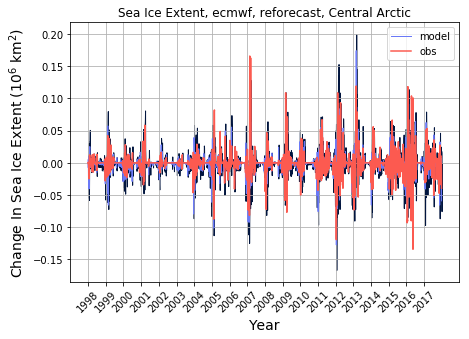

In [100]:
#plt.plot(SIE_obs_sel['SIE'].values,'r')
VAR_NAME_SAVE = 'd_SIE'
TICKS_PER_YEAR = 104 #I use 104 for ECMWFS2S (ecmwf); 48 for meteofr/ukmo and 12 ECMWF-C3S (ecmwfsipn)
IMAGE_FORMAT = 'eps'

SIE_ens_mean = SIE_model_sel.groupby('V (valid date)').mean()
SIE_ens_min = SIE_model_sel.groupby('V (valid date)').min()
SIE_ens_max = SIE_model_sel.groupby('V (valid date)').max()
fig5 = plt.figure(5)
ax5 = fig5.add_axes([0.1,0.1,0.9,0.9])
if model_name == 'ecmwf':
    ax5.plot(SIE_ens_mean['d_SIC (V - I)'].values,color='xkcd:cornflower',linewidth=1)
    plt.fill_between(np.arange(0,len(SIE_ens_min)),SIE_ens_min['d_SIC (V - I)'].values,SIE_ens_max['d_SIC (V - I)'].values,color='xkcd:navy')
else:
    ax5.plot(SIE_ens_mean['d_SIE (V - I)'].values,color='xkcd:cornflower',linewidth=1)
    plt.fill_between(np.arange(0,len(SIE_ens_min)),SIE_ens_min['d_SIE (V - I)'].values,SIE_ens_max['d_SIE (V - I)'].values,color='xkcd:navy')

ax5.plot(SIE_obs_sel['d_SIC (V - I)'].values,color='xkcd:coral')
valid_dates = SIE_model_sel['V (valid date)'].unique().tolist()
valid_yrs = pd.to_datetime(SIE_model_sel['V (valid date)']).dt.year.unique().tolist()
ax5.set_xticks(np.arange(0,len(valid_dates),TICKS_PER_YEAR))
ax5.set_xticklabels((valid_yrs),rotation=45)
ax5.grid()
ax5.set_ylabel('Change In Sea Ice Extent (10$^6$ km$^2$)',fontsize=14)
ax5.set_xlabel('Year',fontsize=14)
ax5.legend(('model','obs'))
ax5.set_title('Sea Ice Extent, {model_name}, {model_type}, {region}'.format(model_name=model_name,
                                                                           model_type=model_type,
                                                                           region=region_sel))
fname_5 = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/{model_name}_{model_type}_{region}_vs_obs_d_SIE_time_series_lead_day_max_{lead_days}.{im_format}'.format(model_name=model_name,
                                                                                                                 model_type=model_type,region=region_sel,lead_days=lead_day_max,
                                                                                                                 im_format=IMAGE_FORMAT)
fig5.savefig(fname_5,format=IMAGE_FORMAT,bbox_inches='tight')

Now, we will make some plots from pivot tables.  This lets us visualize our data as a function of two variables--here, we use <b>year</b> and <b>month</b>, so we can see how the model bias in sea ice extent changes in time, and as a function of month. Thus, data are grouped by the month and year of the valid date. NOTE: change the <code>vmax</code> for <b>panArctic</b> (I use 15) and the other regions (I used 2). <br>

We'll us the <code>pivot_table</code> feature to look at the following: <br>
<li> Observed sea ice extent as a function of month, year; </li>
<li> Model mean sea ice extent as a function of month, year; </li>

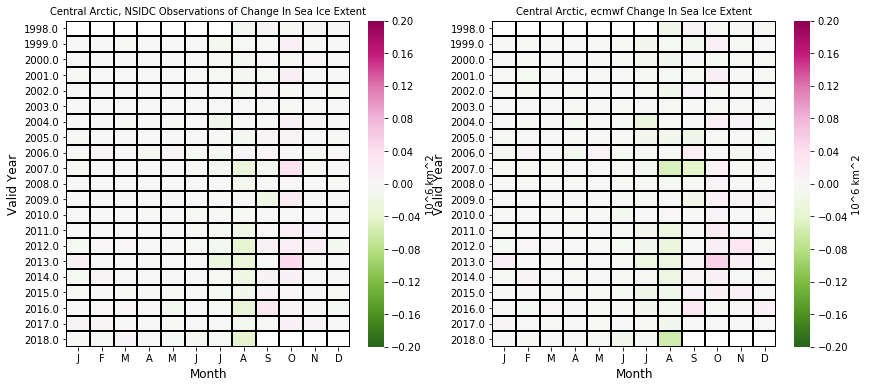

In [101]:
import seaborn as sns
obs_piv_plot = bias_by_yr.pivot_table(index='valid year (obs)',columns='valid month (obs)',values='SIE obs',aggfunc='mean')
obs_piv_plot = obs_piv_plot.astype('float')
#
model_piv_plot = bias_by_yr.pivot_table(index='valid year (model)',columns='valid month (model)',values='SIE ensemble mean (model)',aggfunc='mean')
model_piv_plot = model_piv_plot.astype('float')
vmax = 0.2
fig1,axes1 = plt.subplots(1,2)
fig1.set_figheight(6)
fig1.set_figwidth(14)
ax1a = sns.heatmap(obs_piv_plot,vmin=-vmax,vmax=vmax,cmap='PiYG_r',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax,vmax,11)},ax=axes1[0])
ax1a.set_xlabel('Month',fontsize=12)
ax1a.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax1a.set_ylabel('Valid Year',fontsize=12)
ax1a.set_title('{region}, NSIDC Observations of Change In Sea Ice Extent'.format(region=region_sel),fontsize=10)
#8
ax1b = sns.heatmap(model_piv_plot,vmin=-vmax,vmax=vmax,cmap='PiYG_r',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax,vmax,11)},ax=axes1[1])
ax1b.set_xlabel('Month',fontsize=12)
ax1b.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax1b.set_ylabel('Valid Year',fontsize=12)
ax1b.set_title('{region}, {model_name} Change In Sea Ice Extent'.format(region=region_sel,model_name=model_name),fontsize=10)
fpath_save = '/home/disk/sipn/mcmcgraw/figures/VRILE_v2/bias/chiclet_plots/{VAR_NAME_SAVE}/'.format(VAR_NAME_SAVE=VAR_NAME_SAVE)
fname_1 = fpath_save+'{region}_Obs_and_Model_{model_name}_d_SIE_month_vs_year_lead_day_max_{lead_days}.{im_format}'.format(region=region_sel,
                                                                                                            model_name=model_name,
                                                                                                            lead_days=lead_day_max,
                                                                                                                     im_format=IMAGE_FORMAT)
fig1.savefig(fname_1,format=IMAGE_FORMAT,bbox_inches='tight')

Now, we'll plot the bias (model - obs; right hand plot (above) minus left hand plot (above)) as a function of year and month.  We'll also plot the model spread (max - min).

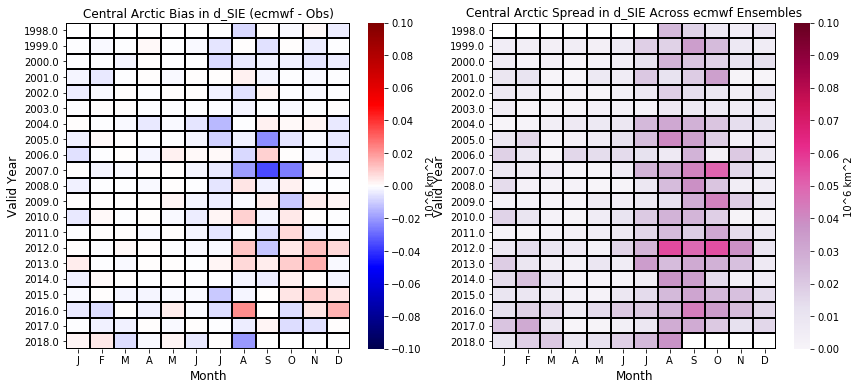

In [102]:
SIE_bias_plot = model_piv_plot - obs_piv_plot
fig2,axes2 = plt.subplots(1,2)
fig2.set_figheight(6)
fig2.set_figwidth(14)
ax2a = sns.heatmap(SIE_bias_plot,vmin=-vmax/2,vmax=vmax/2,cmap='seismic',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(-vmax/2,vmax/2,11)},ax=axes2[0])
ax2a.set_xlabel('Month',fontsize=12)
ax2a.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax2a.set_ylabel('Valid Year',fontsize=12)
ax2a.set_title('{region} Bias in d_SIE ({model_name} - Obs)'.format(region=region_sel,model_name=model_name))
#
SIE_ens_plot = bias_by_yr.pivot_table(index='valid year (obs)',columns='valid month (obs)',values='SIE ensemble spread (max - min)',aggfunc='mean')
SIE_ens_plot = SIE_ens_plot.astype(float)
ax2b = sns.heatmap(SIE_ens_plot,vmin=0,vmax=vmax/2,cmap='PuRd',linewidths=1,
                  linecolor='k',cbar_kws={'label': '10^6 km^2',
                                          'ticks':np.linspace(0,vmax/2,11)},ax=axes2[1])
ax2b.set_xlabel('Month',fontsize=12)
ax2b.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'],rotation=0)
ax2b.set_ylabel('Valid Year',fontsize=12)
ax2b.set_title('{region} Spread in d_SIE Across {model_name} Ensembles'.format(region=region_sel,model_name=model_name))
fname_2 = fpath_save+'{region}_{model_name}_Model_Minus_Obs_and_SPREAD_d_SIE_month_vs_year_lead_day_max_{lead_days}.{im_format}'.format(region=region_sel,
                                                                                                            model_name=model_name,
                                                                                                            lead_days=lead_day_max,
                                                                                                                             im_format=IMAGE_FORMAT)
fig2.savefig(fname_2,format=IMAGE_FORMAT,bbox_inches='tight')

Finally, we'll visualize the top left plot (above; bias) as a line plot. The colors are chronological: earlier years are lighter, later years are darker.  

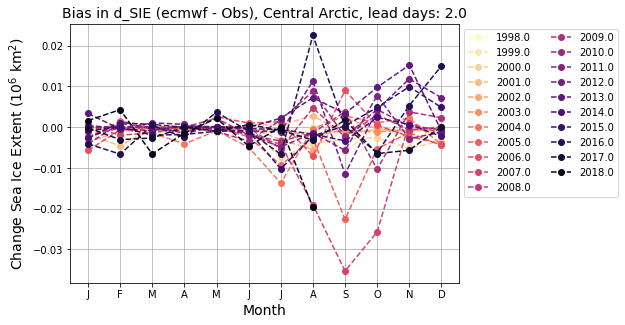

In [103]:
fig6 = plt.figure(6)
from matplotlib import cm
ax6 = fig6.add_axes([0.1,0.1,0.9,0.9])
for i_ind in np.arange(0,len(SIE_bias_plot.index)):
    ax6a = ax6.plot(SIE_bias_plot.iloc[i_ind,:].transpose(),'o--',color=cm.magma_r(i_ind/len(SIE_bias_plot.index)))#,label='_nolegend_')
#yrs = SIE_bias_plot
ax6.legend(SIE_bias_plot.index,bbox_to_anchor=(1,0.8,0.2,0.2),ncol=2)
ax6.set_xticks(np.arange(1,13))
ax6.set_xticklabels(labels=['J','F','M','A','M','J','J','A','S','O','N','D'])
ax6.set_xlabel('Month',fontsize=14)
ax6.set_ylabel('Change Sea Ice Extent (10$^6$ km$^2$)',fontsize=14)
ax6.grid()
ax6.set_title('Bias in d_SIE ({model_name} - Obs), {region}, lead days: {max_lead}'.format(model_name=model_name,region=region_sel,max_lead=lead_day_max),fontsize=14)
fname_6 = fpath_save+'{region}_{model_name}_Model_Minus_Obs_line_plots_d_SIE_month_vs_year_lead_day_max_{lead_days}_COLOR.{im_format}'.format(region=region_sel,
                                                                                                            model_name=model_name,
                                                                                                            lead_days=lead_day_max,im_format=IMAGE_FORMAT)
fig6.savefig(fname_6,format=IMAGE_FORMAT,bbox_inches='tight')
